# 1. Download Training Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import requests

In [2]:
# Connect to Binance api to download training data, no need for keys or authentication, 
# but only accessible from physical machines(does not work on Google Cloud)

root_url = 'https://api.binance.com/api/v3/'

check_url = root_url + 'ping'

if requests.get(check_url).ok != True:
    print('!= 200')


In [3]:
# set api parameters including trading pairs, intervals, and desired timeframes

symbol = 'BTCUSDT' # 'BTCUSDT', 'ETHUSDT', etc.

interval = '1d' # '1m', '1h', '1d'

kline_url = root_url + 'klines'

params = {'interval':interval,
          'symbol':symbol,
          'endTime':1698796800000,
          #'limit':5 # Binance default: 500, max: 1000
         }

In [4]:
# get api data as json

if requests.get(url=kline_url, params=params).ok != True:
    print('Issue with Binance kline API connectivity, did not fetch data')

api_data = requests.get(url=kline_url, params=params).json()

In [5]:
# save json to dataframe

df = pd.DataFrame(api_data)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
          'k_close_time', 'quote_asset_volume', 'num_trades',
          'taker_base_vol', 'taker_quote_vol', 'ignore']

In [6]:
# use for loop to overcome Binance api max limit of 1000 rows per call

for i in range(1):
    prev = df['Date'][0]
    # url_next = url + '&endTime=' + str(prev)
    params['endTime'] = str(prev)
    next_data = requests.get(url=kline_url, params=params).json()
    df_next = pd.DataFrame(next_data)
    df_next.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
          'k_close_time', 'quote_asset_volume', 'num_trades',
          'taker_base_vol', 'taker_quote_vol', 'ignore']
    df = pd.concat([df_next, df]).drop_duplicates()


In [7]:
for col in ['Open', 'High', 'Low', 'Close', 'Volume',
            'quote_asset_volume', 'num_trades',
            'taker_base_vol', 'taker_quote_vol', 'ignore']:
    df[col] = df[col].astype(float)
    
df['Date'] = pd.to_datetime(df['Date'],unit='ms')

In [8]:
df

,Date,Open,High,Low,Close,Volume,k_close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol,ignore
0,2021-02-06,38289.32,40955.51,38215.94,39186.94,98757.311183,1612655999999,3.922095e+09,2291646.0,52015.513362,2.065181e+09,0.0
1,2021-02-07,39181.01,39700.00,37351.00,38795.69,84363.679763,1612742399999,3.256521e+09,1976357.0,40764.388959,1.574483e+09,0.0
2,2021-02-08,38795.69,46794.45,37988.89,46374.87,138597.536914,1612828799999,5.881537e+09,3230961.0,72345.891568,3.069314e+09,0.0
3,2021-02-09,46374.86,48142.19,44961.09,46420.42,115499.861712,1612915199999,5.386255e+09,3119034.0,57429.564347,2.679451e+09,0.0
4,2021-02-10,46420.42,47310.00,43727.00,44807.58,97154.182200,1613001599999,4.431650e+09,2891592.0,47971.985731,2.190231e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2023-10-28,33892.01,34493.33,33860.00,34081.00,16880.131440,1698537599999,5.759365e+08,607438.0,8313.307590,2.836566e+08,0.0
496,2023-10-29,34081.01,34750.11,33930.00,34525.89,20685.521760,1698623999999,7.116530e+08,717480.0,10053.960960,3.459337e+08,0.0
497,2023-10-30,34525.88,34856.00,34062.84,34474.73,33657.959760,1698710399999,1.159772e+09,1117727.0,15237.567810,5.251622e+08,0.0
498,2023-10-31,34474.74,34720.49,34025.00,34639.77,32737.898220,1698796799999,1.125442e+09,1179053.0,15843.795000,5.447229e+08,0.0


In [9]:
# saving to csv

filename = f'{symbol}_{interval}.csv'
df.to_csv(f'../raw_data/{filename}')

# 2. Load Data & Packages

In [10]:
# Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error,  r2_score, accuracy_score
from sklearn.model_selection import train_test_split


2024-01-08 20:22:48.463566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Read data from the CSV file into a DataFrame
data = pd.read_csv("../raw_data/BTCUSDT_1d.csv")

# Select specific columns from the DataFrame
data = data.loc[:,['Date','Open','High','Low','Close','Volume']]

In [12]:
# Set the 'Date' column as the index of the DataFrame
data = data.set_index('Date')

data

,Open,High,Low,Close,Volume
Date,,,,,
2021-02-06,38289.32,40955.51,38215.94,39186.94,98757.311183
2021-02-07,39181.01,39700.00,37351.00,38795.69,84363.679763
2021-02-08,38795.69,46794.45,37988.89,46374.87,138597.536914
2021-02-09,46374.86,48142.19,44961.09,46420.42,115499.861712
2021-02-10,46420.42,47310.00,43727.00,44807.58,97154.182200
...,...,...,...,...,...
2023-10-28,33892.01,34493.33,33860.00,34081.00,16880.131440
2023-10-29,34081.01,34750.11,33930.00,34525.89,20685.521760
2023-10-30,34525.88,34856.00,34062.84,34474.73,33657.959760


# 3. Preprocess Data

In [13]:
#Set the Target column
aim = 'Close'

In [14]:
# 90-10 validation split
val_split_index = int(len(data) * 0.9)
val_data = data.iloc[val_split_index:]
available_data = data.iloc[:val_split_index]

# 80-20 train-test split
split_index = int(len(available_data) * 0.8)
train_data = available_data.iloc[:split_index]
test_data = available_data.iloc[split_index:]


def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    """
    Create a line plot with two lines.
    Parameters:
    - line1 (array-like): Data for the first line.
    - line2 (array-like): Data for the second line.
    - label1 (str, optional): Label for the first line (default is None).
    - label2 (str, optional): Label for the second line (default is None).
    - title (str, optional): Title of the plot (default is an empty string).
    - lw (int, optional): Line width for both lines (default is 2).
    """
    # Create a subplot with specified size
    fig, ax = plt.subplots(1, figsize=(13, 7))

    # Plot the first line with its label
    ax.plot(line1, label=label1, linewidth=lw)

    # Plot the second line with its label
    ax.plot(line2, label=label2, linewidth=lw)

    # Set y-axis label
    ax.set_ylabel('BTC/USDT', fontsize=14)

    # Set the title
    ax.set_title(title, fontsize=16)

    # Add a legend at the best location with the specified font size
    ax.legend(loc='best', fontsize=16)

    # Display the plot
    plt.show()


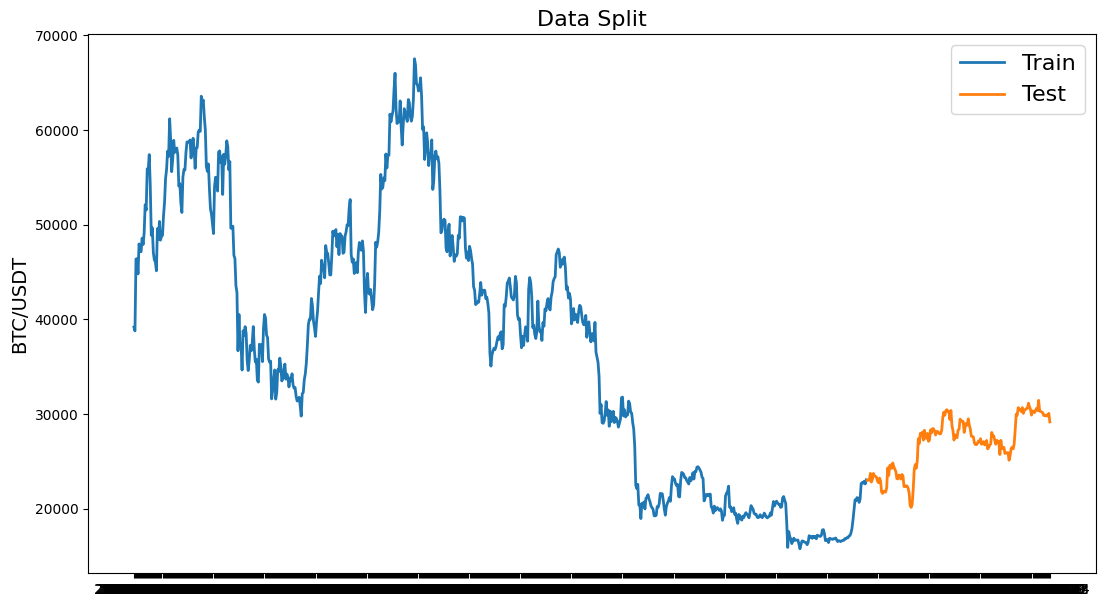

In [15]:
# Plotting the training and testing data for the 'Close' column
line_plot(train_data[aim], test_data[aim], label1='Train', label2='Test', title='Data Split')


In [16]:
# Function to normalize a continuous variable to a zero-base scale
def normalise_zero_base(continuous):
    """
    Normalize a continuous variable to a zero-base scale.
    Parameters:
    - continuous (pandas.Series): The continuous variable to be normalized.
    Returns:
    - pandas.Series: The normalized continuous variable.
    """
    # Normalize by dividing each value by the first value and subtracting 1
    return continuous / continuous.iloc[0] - 1


# Function to normalize a continuous variable to a min-max scale
def normalise_min_max(continuous):
    """
    Normalize a continuous variable to a min-max scale.
    Parameters:
    - continuous (pandas.Series): The continuous variable to be normalized.
    Returns:
    - pandas.Series: The normalized continuous variable.
    """
    # Normalize using min-max scaling formula
    return (continuous - continuous.min()) / (continuous.max() - continuous.min())


In [17]:
# Function to extract windowed data from a continuous variable
def extract_window_data(continuous, window_len=5, zero_base=True):
    """
    Extract windowed data from a continuous variable.
    Parameters:
    - continuous (pandas.Series): The continuous variable to extract windows from.
    - window_len (int, optional): The length of each window (default is 5).
    - zero_base (bool, optional): Whether to normalize each window to a zero-base scale (default is True).
    Returns:
    - numpy.ndarray: Array of windowed data.
    Example:
    >>> windowed_data = extract_window_data(data['Close'], window_len=10, zero_base=True)
    """
    # Initialize an empty list to store windowed data
    window_data = []

    # Iterate over the continuous variable to extract windows
    for idx in range(len(continuous) - window_len):
        # Extract a window of data
        tmp = continuous[idx: (idx + window_len)].copy()

        # Normalize the window to a zero-base scale if specified
        if zero_base:
            tmp = normalise_zero_base(tmp)

        # Append the window data to the list
        window_data.append(tmp.values)

    # Convert the list of windowed data to a numpy array
    return np.array(window_data)


In [18]:
# Function to prepare data for time series analysis
def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    """
    Prepare data for time series analysis.
    Parameters:
    - continuous (pandas.Series): The continuous variable for time series analysis.
    - aim (str): The target variable to predict.
    - window_len (int, optional): The length of each window (default is 10).
    - zero_base (bool, optional): Whether to normalize each window to a zero-base scale (default is True).
    - test_size (float, optional): The proportion of data to be used as the test set (default is 0.2).
    Returns:
    - tuple: A tuple containing train_data, test_data, X_train, X_test, y_train, y_test.
    """
    # Extract windowed data for training and testing sets
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)

    # Extract target variable for training and testing sets
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values

    # Normalize the target variable to a zero-base scale if specified
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    # Return the prepared data
    return train_data, test_data, X_train, X_test, y_train, y_test


In [19]:
# Function to prepare data for time series analysis
def prepare_validation_data(continuous, aim, window_len=10):#, zero_base=True):
    """
    Prepare data for time series analysis.
    Parameters:
    - continuous (pandas.Series): The continuous variable for time series analysis.
    - aim (str): The target variable to predict.
    - window_len (int, optional): The length of each window (default is 10).
    - zero_base (bool, optional): Whether to normalize each window to a zero-base scale (default is True).
    - test_size (float, optional): The proportion of data to be used as the test set (default is 0.2).
    Returns:
    - tuple: A tuple containing train_data, test_data, X_train, X_test, y_train, y_test.
    """
    # Extract windowed data for validation set
    X_val = extract_window_data(val_data, window_len, zero_base)

    # Extract target variable for validation set
    y_val = val_data[aim][window_len:].values

    # Normalize the target variable to a zero-base scale if specified
    # if zero_base:
    #     y_train = y_train / train_data[aim][:-window_len].values - 1
    #     y_test = y_test / test_data[aim][:-window_len].values - 1

    # Return the prepared data
    return val_data, X_val, y_val


# 4. LSTM Model

In [ ]:
# Function to build an LSTM (Long Short-Term Memory) model# Function to build an LSTM (Long Short-Term Memory) model
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam', metrics='mae'):
    """
    Build an LSTM (Long Short-Term Memory) model.
    Parameters:
    - input_data (numpy.ndarray): The input data for the model.
    - output_size (int): The size of the output layer.
    - neurons (int): The number of neurons in the LSTM layer.
    - activ_func (str, optional): Activation function for the output layer (default is 'linear').
    - dropout (float, optional): Dropout rate to prevent overfitting (default is 0.2).
    - loss (str, optional): Loss function for model training (default is 'mse' - Mean Squared Error).
    - optimizer (str, optional): Optimization algorithm for model training (default is 'adam').
    Returns:
    - tensorflow.keras.models.Sequential: The constructed LSTM model.
    """
    # Create a Sequential model
    model = Sequential()

    # Add an LSTM layer with the specified number of neurons and input shape
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))

    # Add a Dropout layer to prevent overfitting
    model.add(Dropout(dropout))

    # Add a Dense layer with the specified number of units
    model.add(Dense(units=output_size))

    # Add an Activation layer with the specified activation function
    model.add(Activation(activ_func))

    # Compile the model with the specified loss function and optimizer
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the constructed LSTM model
    return model


In [ ]:
# Define parameters for data preparation and LSTM model
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'
output_size = 1

# Prepare data for time series analysis
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    available_data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [20]:
#  Prepare 
val_data, X_val, y_val = prepare_validation_data(val_data, aim=aim, window_len=window_len)

NameError: name 'window_len' is not defined

In [ ]:
available_data.shape

In [ ]:
val_data.shape

In [ ]:
# train_data, test_data, X_train_val, X_test_val, y_train_val, y_test_val = prepare_data(
#     val_data, aim, window_len=window_len, zero_base=True, test_size=0)

In [ ]:
# Build an LSTM model
model = build_lstm_model(
    X_train, output_size=output_size, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)

# Train the LSTM model
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)


In [ ]:
# modelfit.history

# 5. Results

In [ ]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS --- 

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    # ax[0].set_ylim((0,3))

    ax[0].legend(['Train', 'Test'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])

    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Test'], loc='best')

    # ax[1].set_ylim((0,1))

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

In [ ]:
plot_loss_accuracy(modelfit)

In [ ]:
# Plotting the training and validation loss during model training
plt.plot(modelfit.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g', linewidth=2, label='Validation loss')

# Set plot title and axis labels
plt.title('LSTM Neural Networks - BTC Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')

# Display legend to distinguish between training and validation loss
plt.legend()

# Show the plot
plt.show()


In [ ]:
X_test.shape

In [ ]:
val_data[aim][window_len:]

In [ ]:
# Extract the target values from the validation dataset
targets = val_data[aim][window_len:]

# Make predictions using the trained LSTM model on the validation data
preds = model.predict(X_val).squeeze()

# Calculate the Mean Absolute Error (MAE) between predictions and actual targets
mae = mean_absolute_error(preds, y_val)

# Display the actual target values
targets.round()


In [ ]:
# Generate final predictions by reversing the normalization process
preds = val_data[aim].values[:-window_len] * (preds + 1)

# Create a pandas Series with index and data for predictions
preds = pd.Series(index=targets.index, data=preds)

# Plotting the actual and predicted values
line_plot(targets, preds, 'actual', 'prediction', lw=3)


In [ ]:
# Turn preds to numpy array for MSE and R2 calculations
preds = preds.values

# Calculate the Mean Squared Error (MSE) between predictions and actual targets
SCORE_MSE = mean_squared_error(preds, y_val)

# Display the calculated MSE score
SCORE_MSE


In [ ]:
SCORE_MSE

In [ ]:
hello_true = [1, 2, 3]
hello_pred = [1.1, 2.0, 2.9]

score = r2_score(hello_true, hello_pred)

In [ ]:
# Calculate the R-squared (R2) score between actual targets and predicted values
r2 = r2_score(y_val, preds)

# Multiply the R2 score by 100 for percentage representation
r2 * 100


# 6. Preprocess Data for Binary Classification 

In [ ]:
# Assuming 'data' is the DataFrame containing time series data
data['aim_binary'] = (data['Close'] > data['Close'].shift(1)).astype(int)

# Drop NaN values introduced by the shift operation
data = data.dropna()
data.head()


In [ ]:
# def prepare_data_binary(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
#     X_train = extract_window_data(train_data[continuous.columns], window_len, zero_base)
#     X_test = extract_window_data(test_data[continuous.columns], window_len, zero_base)
#     y_train = train_data[aim][window_len:].values
#     y_test = test_data[aim][window_len:].values
#     if zero_base:
#         y_train = y_train / train_data[aim][:-window_len].values - 1
#         y_test = y_test / test_data[aim][:-window_len].values - 1

#     return train_data, test_data, X_train, X_test, y_train, y_test


In [ ]:
# Prepare data for binary classification
aim_binary = 'aim_binary'
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[aim_binary]), data[aim_binary], test_size=0.2, shuffle=False)


# 7. Binary Classification Model

In [ ]:
# Function to build a binary classification model
def build_binary_classification_model(input_data, output_size, neurons, activ_func='sigmoid', dropout=0.3, loss='binary_crossentropy', optimizer='adam'):
    model2 = Sequential()
    # Assuming your time series data has only one feature (e.g., 'Close' column)
    model2.add(LSTM(neurons, input_shape=(X_train.shape[1], 1)))  # Adjust the input shape
    model2.add(Dropout(dropout))
    model2.add(Dense(units=output_size))
    model2.add(Activation(activ_func))
    model2.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model2


In [ ]:
# Specify parameters for the binary classification model
binary_lstm_neurons = 50
binary_epochs = 20
batch_size = 32


In [ ]:
# Build the binary classification model
binary_model = build_binary_classification_model(X_train, output_size=1, neurons=binary_lstm_neurons)

# Train the binary classification model
binary_modelfit = binary_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=binary_epochs, batch_size=batch_size, verbose=1, shuffle=False)


# 8. Binary Classification 

In [ ]:
# Plotting the training and validation loss during model training
plt.plot(binary_modelfit.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(binary_modelfit.history['val_loss'], 'g', linewidth=2, label='Validation loss')

# Set plot title and axis labels
plt.title('LSTM Neural Networks - BTC Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')

# Display legend to distinguish between training and validation loss
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Make predictions using the trained binary classification model on the test data
binary_preds = (binary_model.predict(X_test) > 0.5).astype(int)

# Extract the binary target values from the test dataset
binary_targets = y_test.astype(int)

# Display the actual binary target values
print("Actual Binary Targets:")
print(binary_targets)

# Display the predicted binary target values
print("Predicted Binary Targets:")
print(binary_preds)


In [ ]:
# Evaluate the binary classification model
binary_preds = (binary_model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_preds)
print(f'Accuracy: {accuracy}')
